In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

import yfinance as yf
import datetime
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Google stock data from Yahoo Finance
start_date = '2021-01-01'
end_date = '2024-11-30'
df = yf.download('GOOG', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [3]:
# Display the first five rows
print("First five rows of the dataset:")
df.head()


First five rows of the dataset:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2021-01-04,86.200310,86.412003,88.032501,85.392502,87.876999,38038000
2021-01-05,86.832756,87.045998,87.383499,85.900749,86.250000,22906000
2021-01-06,86.551941,86.764503,87.400002,84.949997,85.131500,52042000
2021-01-07,89.143578,89.362503,89.419998,86.852501,87.002998,45300000
2021-01-08,90.139130,90.360497,90.491997,88.676750,89.399002,41012000


In [4]:
# Display the first five rows
print("Last five rows of the dataset:")
df.tail()

Last five rows of the dataset:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2024-11-22,166.570007,166.570007,168.264999,165.710007,167.160004,24497000
2024-11-25,169.429993,169.429993,170.460007,167.399994,167.990005,21395700
2024-11-26,170.619995,170.619995,171.494995,169.429993,169.490005,14937500
2024-11-27,170.820007,170.820007,171.139999,169.669998,170.679993,12433400
2024-11-29,170.490005,170.490005,170.869995,168.750000,170.059998,9250700


In [5]:
# Statistical summary
print("\nStatistical summary of the dataset:")
df.describe()


Statistical summary of the dataset:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
count,984.000000,984.000000,984.000000,984.000000,984.000000,9.840000e+02
mean,129.947381,130.229311,131.618411,128.826308,130.154110,2.486143e+07
std,24.771823,24.772173,24.879915,24.700776,24.850911,1.044442e+07
min,83.285461,83.489998,86.550003,83.449997,85.131500,7.409100e+06
25%,109.962452,110.232498,111.878628,108.127186,109.676502,1.788328e+07
50%,130.277061,130.597000,132.446747,129.608749,130.942001,2.252595e+07
75%,144.030533,144.384254,145.708122,143.065998,144.480495,2.874378e+07
max,192.406723,192.660004,193.309998,190.619995,191.750000,9.779860e+07



Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 984 entries, 2021-01-04 to 2024-11-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GOOG)  984 non-null    float64
 1   (Close, GOOG)      984 non-null    float64
 2   (High, GOOG)       984 non-null    float64
 3   (Low, GOOG)        984 non-null    float64
 4   (Open, GOOG)       984 non-null    float64
 5   (Volume, GOOG)     984 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 53.8 KB
None


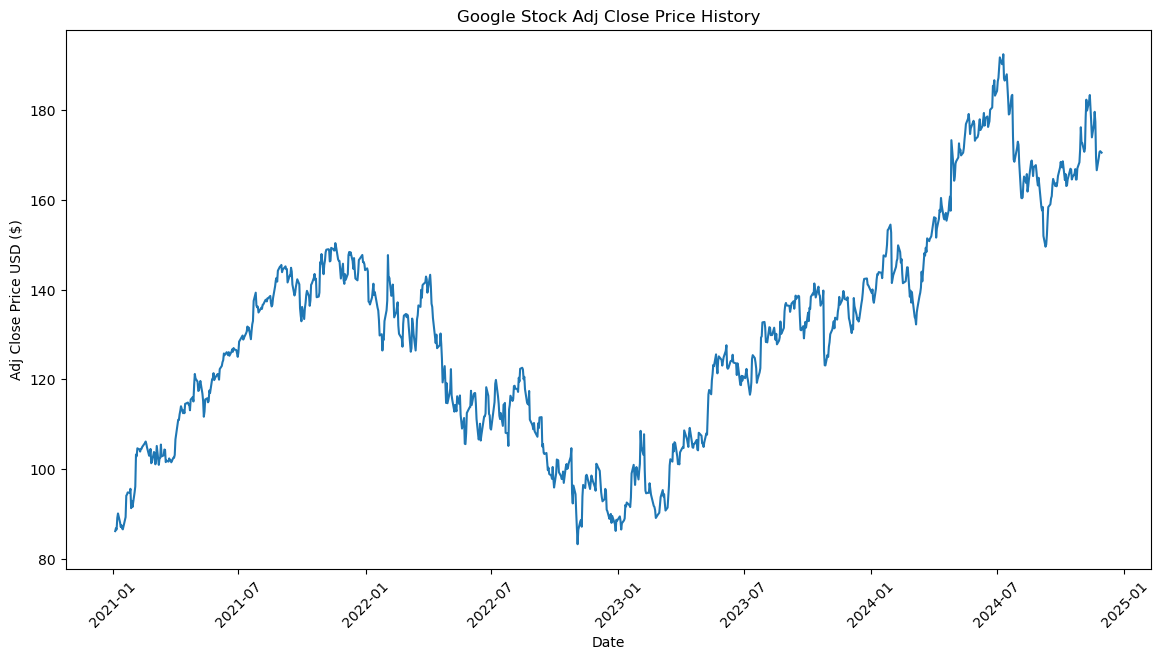

In [6]:


# Dataset information
print("\nInformation about the dataset:")
print(df.info())

# Visualize Adj Close prices over time
plt.figure(figsize=(14, 7))
plt.plot(df['Adj Close'])
plt.title('Google Stock Adj Close Price History')
plt.xlabel('Date')
plt.ylabel('Adj Close Price USD ($)')
plt.xticks(rotation=45)
plt.show()


In [7]:
# Define sequence length and test days
sequence_length = 5  # Number of days to use for sequences
#test_days = sequence_length  # Use 5 days for testing

# Split into training/validation and test sets
df_train = df[:500]
df_val = df[500:632]
df_test = df[632:732]
#df_actual = df[60:65]

print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")
print(f"Test data shape: {df_test.shape}")
#print(f"Actual data shape: {df_actual.shape}")



Training data shape: (500, 6)
Validation data shape: (132, 6)
Test data shape: (100, 6)


In [8]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training data
train_data = df_train[['Close']].values
train_scaled = scaler.fit_transform(train_data)

# Transform validation and test data
val_data = df_val[['Close']].values
val_scaled = scaler.transform(val_data)

test_data = df_test[['Close']].values
test_scaled = scaler.transform(test_data)


In [9]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=5):
        self.sequence_length = sequence_length
        self.data = data

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length]
        y = self.data[index+self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001,
                criterion=nn.MSELoss(), optimizer_name='Adam', early_stopping_patience=5):

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
    model.to(device)
    criterion.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    patience = early_stopping_patience
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * x_val.size(0)

            val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}')

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience = early_stopping_patience  # Reset patience
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping")
                    model.load_state_dict(best_model_state)
                    break

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


In [11]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    best_loss = min(val_losses)
    print(f'Best Validation Loss: {best_loss}')


In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
sequence_length = 60
batch_size = 64

# Prepare datasets and dataloaders
train_dataset = StockDataset(train_scaled, sequence_length)
val_dataset = StockDataset(val_scaled, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_size = 1
hidden_size = 50
num_layers = 1
dropout = 0.0
learning_rate = 0.0001
num_epochs = 2000
optimizer_name = 'Adam'
early_stopping_patience = 10

# Initialize model and loss function
model = LSTMModel(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()

# Train the model
model, train_losses, val_losses = train_model(model, train_loader, val_loader,
                                              num_epochs=num_epochs,
                                              learning_rate=learning_rate,
                                              criterion=criterion,
                                              optimizer_name=optimizer_name,
                                              early_stopping_patience=early_stopping_patience)


Epoch 1/2000, Train Loss: 0.402605, Val Loss: 0.219149
Epoch 2/2000, Train Loss: 0.390505, Val Loss: 0.210439
Epoch 3/2000, Train Loss: 0.378884, Val Loss: 0.201914
Epoch 4/2000, Train Loss: 0.367429, Val Loss: 0.193516
Epoch 5/2000, Train Loss: 0.356073, Val Loss: 0.185212
Epoch 6/2000, Train Loss: 0.344766, Val Loss: 0.176969
Epoch 7/2000, Train Loss: 0.333457, Val Loss: 0.168756
Epoch 8/2000, Train Loss: 0.322099, Val Loss: 0.160543
Epoch 9/2000, Train Loss: 0.310642, Val Loss: 0.152301
Epoch 10/2000, Train Loss: 0.299039, Val Loss: 0.144004
Epoch 11/2000, Train Loss: 0.287245, Val Loss: 0.135629
Epoch 12/2000, Train Loss: 0.275217, Val Loss: 0.127153
Epoch 13/2000, Train Loss: 0.262910, Val Loss: 0.118558
Epoch 14/2000, Train Loss: 0.250279, Val Loss: 0.109826
Epoch 15/2000, Train Loss: 0.237279, Val Loss: 0.100944
Epoch 16/2000, Train Loss: 0.223863, Val Loss: 0.091905
Epoch 17/2000, Train Loss: 0.209988, Val Loss: 0.082712
Epoch 18/2000, Train Loss: 0.195611, Val Loss: 0.073380
E

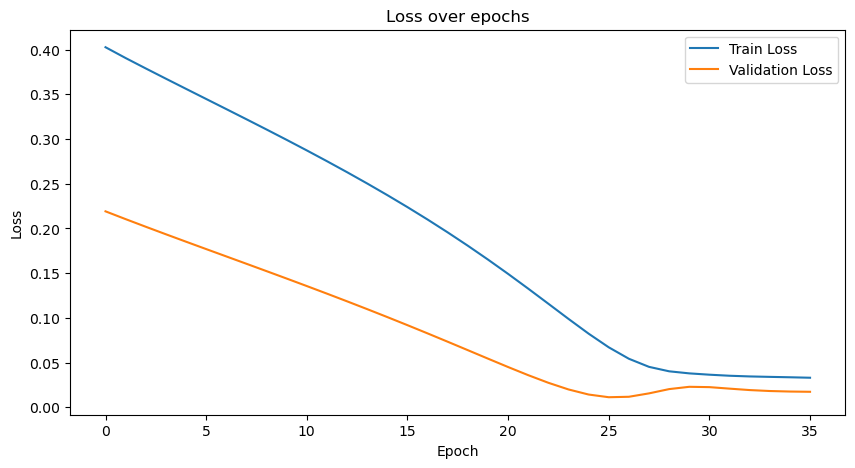

Best Validation Loss: 0.011358345444831584


In [13]:
# Plot training and validation loss curves
plot_losses(train_losses, val_losses)


In [14]:
# Save the trained base model and scaler
torch.save(model.state_dict(), 'lstm_base_model.pth')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [15]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'num_layers': [1, 2, 3],
    'hidden_size': [50, 100],
    'dropout': [0.0, 0.2, 0.3],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32],
    'num_epochs':[2000],
    'optimizer_name': ['Adam'],
    'early_stopping_patience': [10]
    
}

param_list = list(ParameterGrid(param_grid))

best_model = None
best_val_loss = np.inf
best_params = None

for params in param_list:
    print(f"\nTraining with parameters: {params}")
    # Update batch_size
    batch_size = params['batch_size']

    # Create new DataLoaders with updated batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model with current parameters
    opt_model = LSTMModel(input_size=input_size, hidden_size=params['hidden_size'],
                      num_layers=params['num_layers'], dropout=params['dropout'])
    criterion = nn.MSELoss()

    # Train model
    opt_model, opt_train_losses, opt_val_losses = train_model(opt_model, train_loader, val_loader,
                                                  num_epochs=params['num_epochs'],
                                                  learning_rate=params['learning_rate'],
                                                  criterion=criterion,
                                                  optimizer_name='Adam',
                                                  early_stopping_patience=params['early_stopping_patience'])

    # Get final validation loss
    val_loss = opt_val_losses[-1]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = opt_model
        best_params = params
        best_train_losses = opt_train_losses
        best_val_losses = opt_val_losses

print(f"\nBest parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")



Training with parameters: {'batch_size': 32, 'dropout': 0.0, 'early_stopping_patience': 10, 'hidden_size': 50, 'learning_rate': 0.001, 'num_epochs': 2000, 'num_layers': 1, 'optimizer_name': 'Adam'}
Epoch 1/2000, Train Loss: 0.519990, Val Loss: 0.214728
Epoch 2/2000, Train Loss: 0.290153, Val Loss: 0.013163
Epoch 3/2000, Train Loss: 0.090628, Val Loss: 0.012382
Epoch 4/2000, Train Loss: 0.096578, Val Loss: 0.017629
Epoch 5/2000, Train Loss: 0.079835, Val Loss: 0.028555
Epoch 6/2000, Train Loss: 0.046220, Val Loss: 0.022467
Epoch 7/2000, Train Loss: 0.042897, Val Loss: 0.014125
Epoch 8/2000, Train Loss: 0.043544, Val Loss: 0.017113
Epoch 9/2000, Train Loss: 0.036999, Val Loss: 0.014042
Epoch 10/2000, Train Loss: 0.034014, Val Loss: 0.011956
Epoch 11/2000, Train Loss: 0.029549, Val Loss: 0.009802
Epoch 12/2000, Train Loss: 0.024042, Val Loss: 0.006662
Epoch 13/2000, Train Loss: 0.016960, Val Loss: 0.003701
Epoch 14/2000, Train Loss: 0.010038, Val Loss: 0.005700
Epoch 15/2000, Train Loss:

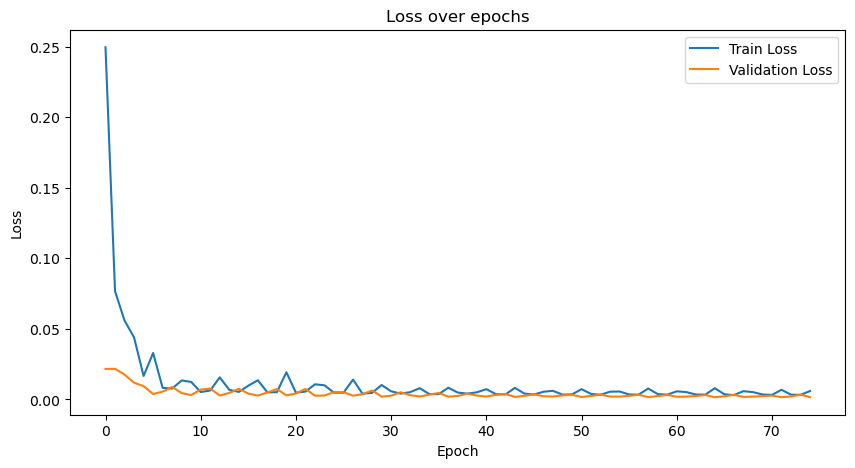

Best Validation Loss: 0.0015819234734711547


In [16]:
# Plot training and validation loss curves for the best model
plot_losses(best_train_losses, best_val_losses)


In [17]:
# Save the optimized model
torch.save(best_model.state_dict(), 'lstm_best_model.pth')


In [18]:
# Prepare test dataset and dataloader
sequence_length = 60
test_dataset = StockDataset(test_scaled, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#actual_dataset = StockDataset(df_actual, sequence_length)
#actual_loader = DataLoader(actual_dataset, batch_size=1, shuffle=False)

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.load_state_dict(torch.load('lstm_best_model.pth'))
best_model.to(device)
best_model.eval()

# Evaluate the model on the test set
predictions = []
actuals = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        output = best_model(x_test)
        predictions.append(output.item())
        actuals.append(y_test.item())


In [19]:
# Convert lists to numpy arrays and reshape
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

# Inverse transform to get actual prices
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Compute RMSE
mse = mean_squared_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mse)
print(f'\nTest MSE: {mse}')
print(f'\nTest RMSE: {rmse}')



Test MSE: 21.00919926340875

Test RMSE: 4.583579306983654


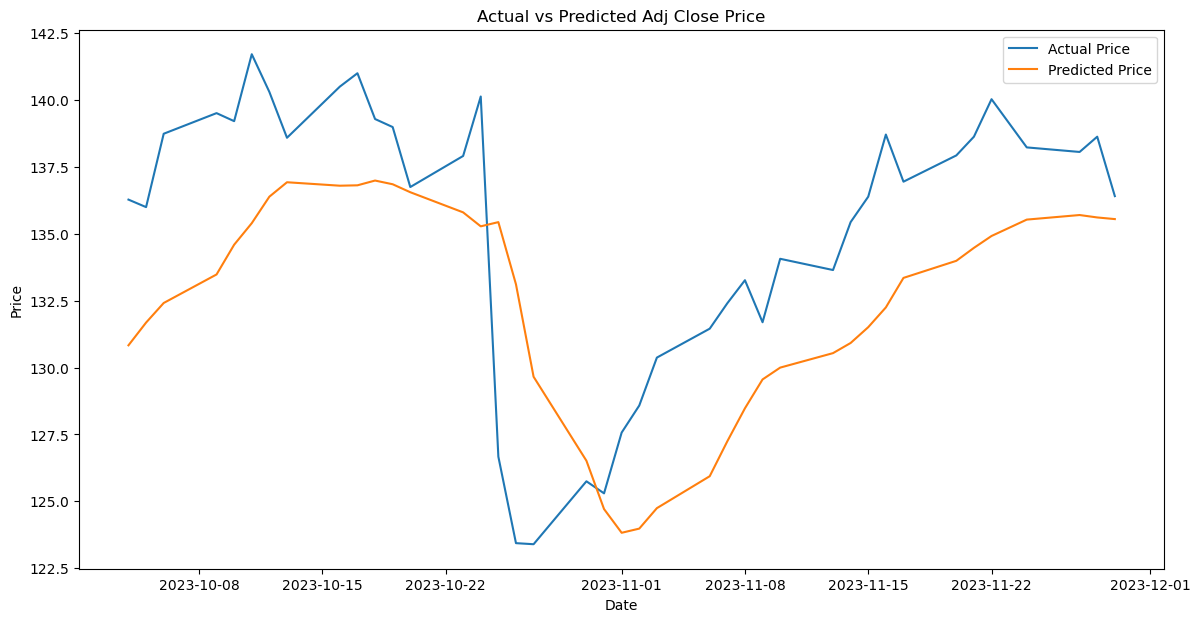


Comparison of Actual and Predicted Prices:
         Date      Actual   Predicted
0  2023-10-04  136.270005  130.828494
1  2023-10-05  135.990007  131.677873
2  2023-10-06  138.729996  132.409272
3  2023-10-09  139.500002  133.474337
4  2023-10-10  139.199998  134.586030
5  2023-10-11  141.699998  135.389939
6  2023-10-12  140.289992  136.380106
7  2023-10-13  138.580002  136.918468
8  2023-10-16  140.490004  136.789625
9  2023-10-17  140.990007  136.804057
10 2023-10-18  139.279997  136.982108
11 2023-10-19  138.979994  136.843681
12 2023-10-20  136.740004  136.545889
13 2023-10-23  137.899992  135.793845
14 2023-10-24  140.119994  135.272090
15 2023-10-25  126.670000  135.429492
16 2023-10-26  123.440004  133.106887
17 2023-10-27  123.400002  129.654951
18 2023-10-30  125.750001  126.517646
19 2023-10-31  125.300003  124.713086
20 2023-11-01  127.569999  123.827266
21 2023-11-02  128.580001  123.983178
22 2023-11-03  130.369994  124.747181
23 2023-11-06  131.449996  125.939972
24 202

In [20]:
# Prepare dates for plotting
test_dates = df_test.index[sequence_length:]

# Create a DataFrame for comparison
result_df = pd.DataFrame({'Date': test_dates,
                          'Actual': actuals_inv.flatten(),
                          'Predicted': predictions_inv.flatten()})

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(result_df['Date'], result_df['Actual'], label='Actual Price')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Adj Close Price')
plt.legend()
plt.show()

# Display the comparison table
print("\nComparison of Actual and Predicted Prices:")
print(result_df)


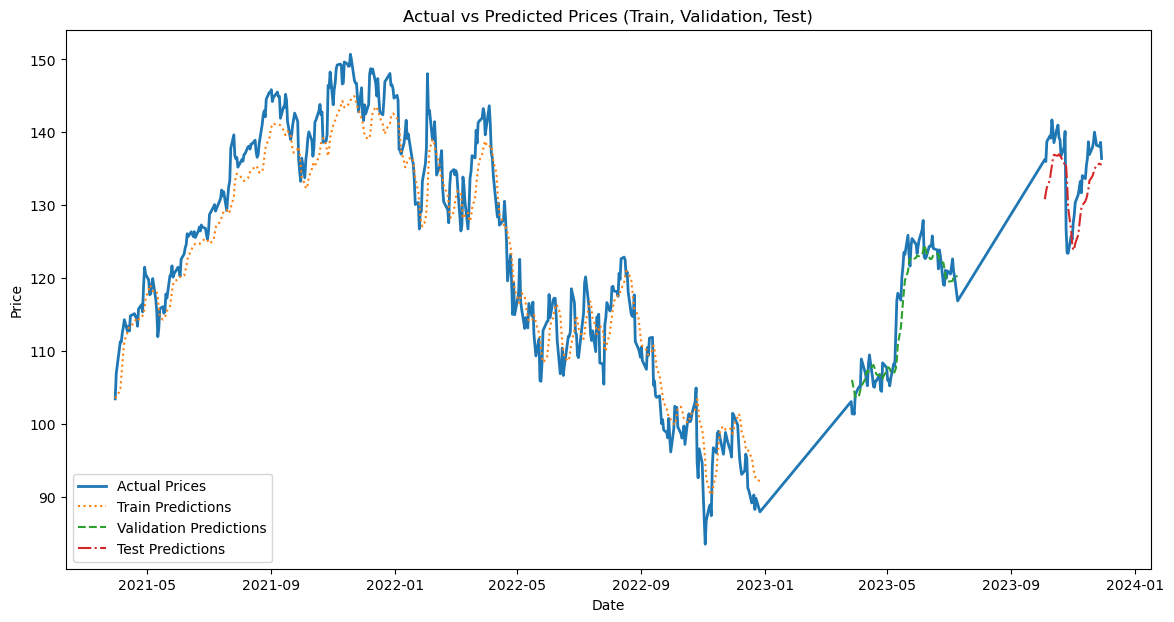


Combined Results (First 10 Rows):
        Date      Actual Train Predictions Validation Predictions  \
0 2021-03-31  103.431504        103.502636                   None   
1 2021-04-01  106.887496        103.750879                   None   
2 2021-04-05  111.277495        104.605928                   None   
3 2021-04-06  111.237504        106.370275                   None   
4 2021-04-07  112.484000        108.216688                   None   
5 2021-04-08  113.272003        109.923962                   None   
6 2021-04-09  114.293998        111.345054                   None   
7 2021-04-12  112.739503        112.524274                   None   
8 2021-04-13  113.363503        113.066539                   None   
9 2021-04-14  112.741997         113.31975                   None   

  Test Predictions  
0             None  
1             None  
2             None  
3             None  
4             None  
5             None  
6             None  
7             None  
8             No

In [21]:
def predict_and_visualize(model, train_dataset, val_dataset, test_dataset, scaler, df_train, df_val, df_test, sequence_length):
    model.eval()
    predictions_train, actuals_train = [], []
    predictions_val, actuals_val = [], []
    predictions_test, actuals_test = [], []
    
    # Helper function to generate predictions
    def generate_predictions(dataset, loader):
        predictions, actuals = [], []
        with torch.no_grad():
            for x_batch, y_batch in loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(x_batch)
                predictions.append(outputs.item())
                actuals.append(y_batch.item())
        return predictions, actuals

    # Generate predictions for training dataset
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    predictions_train, actuals_train = generate_predictions(train_dataset, train_loader)

    # Generate predictions for validation dataset
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    predictions_val, actuals_val = generate_predictions(val_dataset, val_loader)

    # Generate predictions for test dataset
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    predictions_test, actuals_test = generate_predictions(test_dataset, test_loader)

    # Inverse transform the predictions and actuals
    predictions_train_inv = scaler.inverse_transform(np.array(predictions_train).reshape(-1, 1))
    actuals_train_inv = scaler.inverse_transform(np.array(actuals_train).reshape(-1, 1))

    predictions_val_inv = scaler.inverse_transform(np.array(predictions_val).reshape(-1, 1))
    actuals_val_inv = scaler.inverse_transform(np.array(actuals_val).reshape(-1, 1))

    predictions_test_inv = scaler.inverse_transform(np.array(predictions_test).reshape(-1, 1))
    actuals_test_inv = scaler.inverse_transform(np.array(actuals_test).reshape(-1, 1))

    # Combine results into a DataFrame for visualization
    train_dates = df_train.index[sequence_length:]
    val_dates = df_val.index[sequence_length:]
    test_dates = df_test.index[sequence_length:]

    combined_df = pd.DataFrame({
        'Date': np.concatenate([train_dates, val_dates, test_dates]),
        'Actual': np.concatenate([actuals_train_inv.flatten(), actuals_val_inv.flatten(), actuals_test_inv.flatten()]),
        'Train Predictions': np.concatenate([predictions_train_inv.flatten(), [None] * (len(val_dates) + len(test_dates))]),
        'Validation Predictions': np.concatenate([[None] * len(train_dates), predictions_val_inv.flatten(), [None] * len(test_dates)]),
        'Test Predictions': np.concatenate([[None] * (len(train_dates) + len(val_dates)), predictions_test_inv.flatten()]),
    })

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(combined_df['Date'], combined_df['Actual'], label='Actual Prices', linewidth=2)
    plt.plot(combined_df['Date'], combined_df['Train Predictions'], label='Train Predictions', linestyle='dotted')
    plt.plot(combined_df['Date'], combined_df['Validation Predictions'], label='Validation Predictions', linestyle='dashed')
    plt.plot(combined_df['Date'], combined_df['Test Predictions'], label='Test Predictions', linestyle='dashdot')
    plt.title('Actual vs Predicted Prices (Train, Validation, Test)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return combined_df

# Predict and visualize
combined_results = predict_and_visualize(
    best_model,
    train_dataset,
    val_dataset,
    test_dataset,
    scaler,
    df_train,
    df_val,
    df_test,
    sequence_length
)

# Display the combined DataFrame
print("\nCombined Results (First 10 Rows):")
print(combined_results.head(10))


In [26]:
def generate_predictions(model, dataset, scaler, device, sequence_length):
    """
    Generate predictions for a given dataset using the trained model.
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    predictions, actuals = [], []
    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            predictions.append(outputs.item())
            actuals.append(y_batch.item())

    # Inverse transform predictions and actuals to original scale
    predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals_inv = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions_inv, actuals_inv


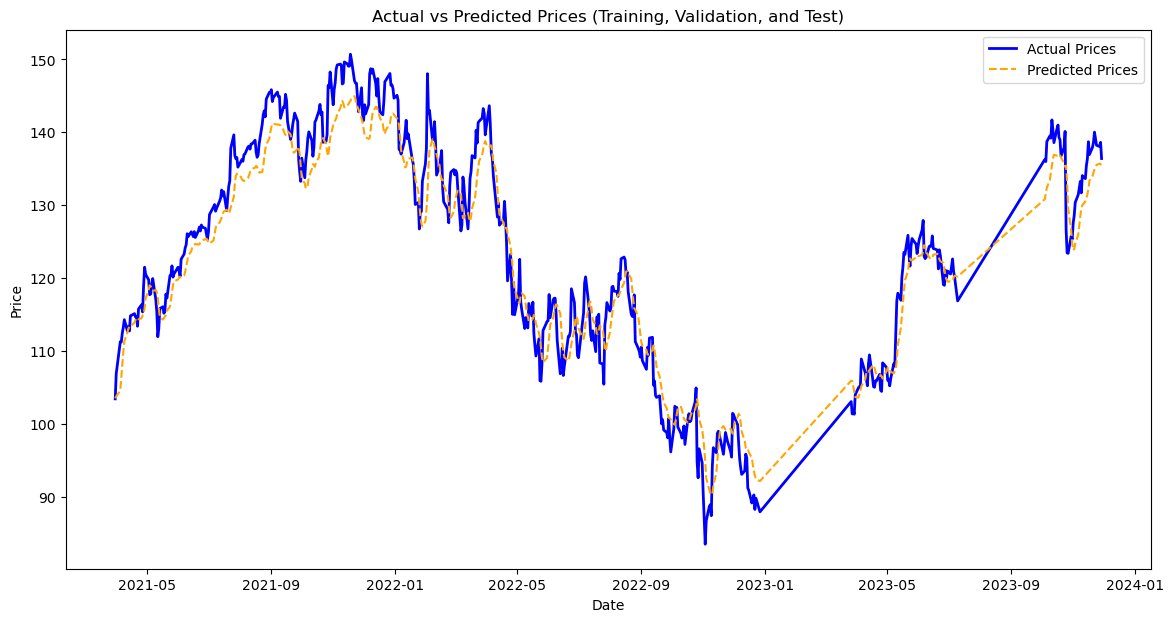

Combined results saved to 'combined_results_with_actual.csv'


In [28]:
# Step 1: Generate predictions for training, validation, and test datasets
predictions_train, actuals_train = generate_predictions(
    model=best_model,
    dataset=train_dataset,
    scaler=scaler,
    device=device,
    sequence_length=sequence_length
)

predictions_val, actuals_val = generate_predictions(
    model=best_model,
    dataset=val_dataset,
    scaler=scaler,
    device=device,
    sequence_length=sequence_length
)

predictions_test, actuals_test = generate_predictions(
    model=best_model,
    dataset=test_dataset,
    scaler=scaler,
    device=device,
    sequence_length=sequence_length
)

# Step 2: Visualize predictions and actual data
combined_results = visualize_predictions_with_actual(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    predictions_train=predictions_train,
    actuals_train=actuals_train,
    predictions_val=predictions_val,
    actuals_val=actuals_val,
    predictions_test=predictions_test,
    actuals_test=actuals_test,
    sequence_length=sequence_length
)

# Step 3: Save the combined results to a CSV file
combined_results.to_csv('combined_results_with_actual.csv', index=False)
print("Combined results saved to 'combined_results_with_actual.csv'")
